In [1]:
import time
import sys
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import seaborn as sns
import pandas as pd

from veloproj import *
from veloproj.model import leastsq_pt
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.h5ad',
                               '--model-name', 'scEU_model.cpt',
                               '--exp-name', 'CohAE_scEU',
                               '--device', 'cuda:3',
                               '--nb_g_src', "SU",
                               '--gumbsoft_tau', '1',
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'conn

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


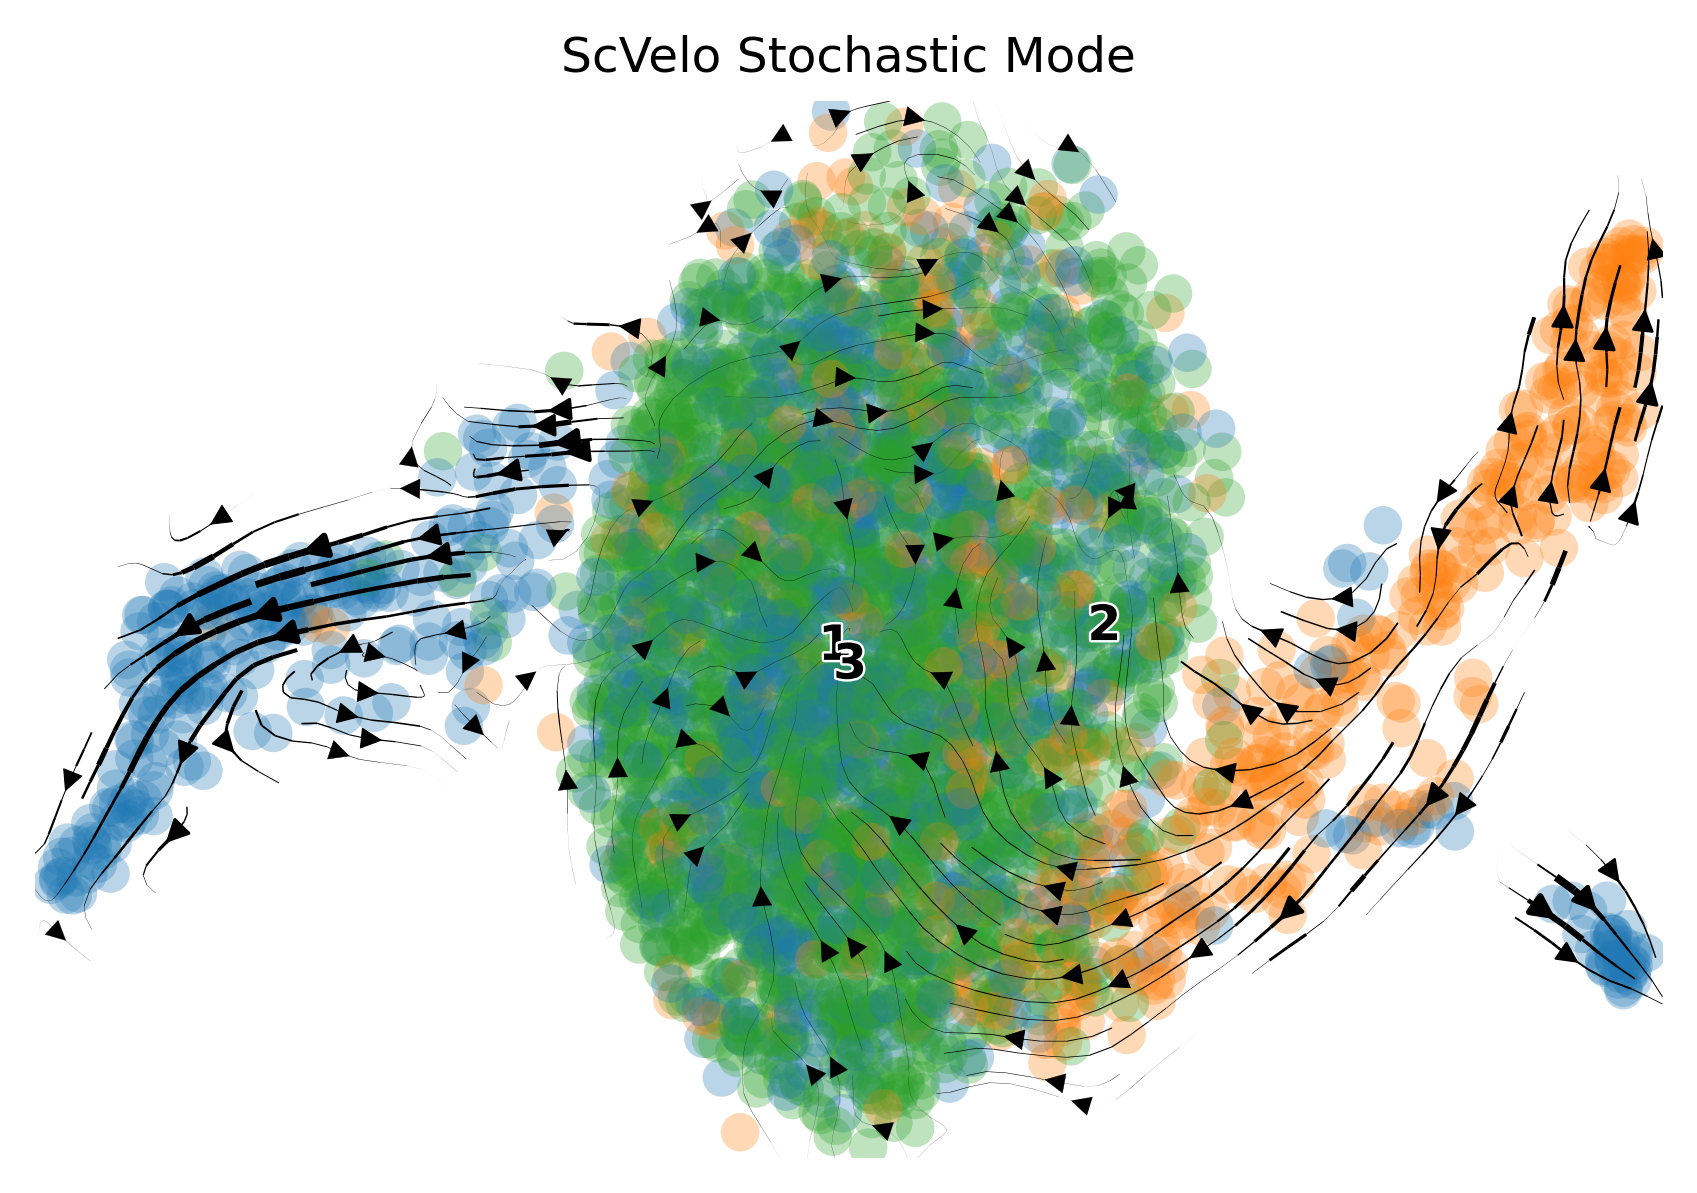

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15114777, ('3', '2'): 0.08071256}
Total Mean: 0.11593016237020493
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79889697, ('3', '2'): 0.8207498}
Total Mean: 0.8098233938217163
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10821400009650162, ('3', '2'): 0.07437119337077965}
Total Mean: 0.09129259673364062
# In-cluster Coherence
{'1': 0.8049664, '2': 0.8545274, '3': 0.83366334}
Total Mean: 0.8310523629188538
# In-cluster Confidence
{'1': 0.7199635048156345, '2': 0.7906047247751308, '3': 0.7805492314829755}
Total Mean: 0.7637058203579136


In [6]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['monocle_branch_id'],
                                 dpi=350,
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")
exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

recovering dynamics (using 10/40 cores)


  0%|          | 0/2000 [00:00<?, ?gene/s]

    finished (0:01:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:12) --> added 
    'dyn_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'dyn_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dyn_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_dynamical.png


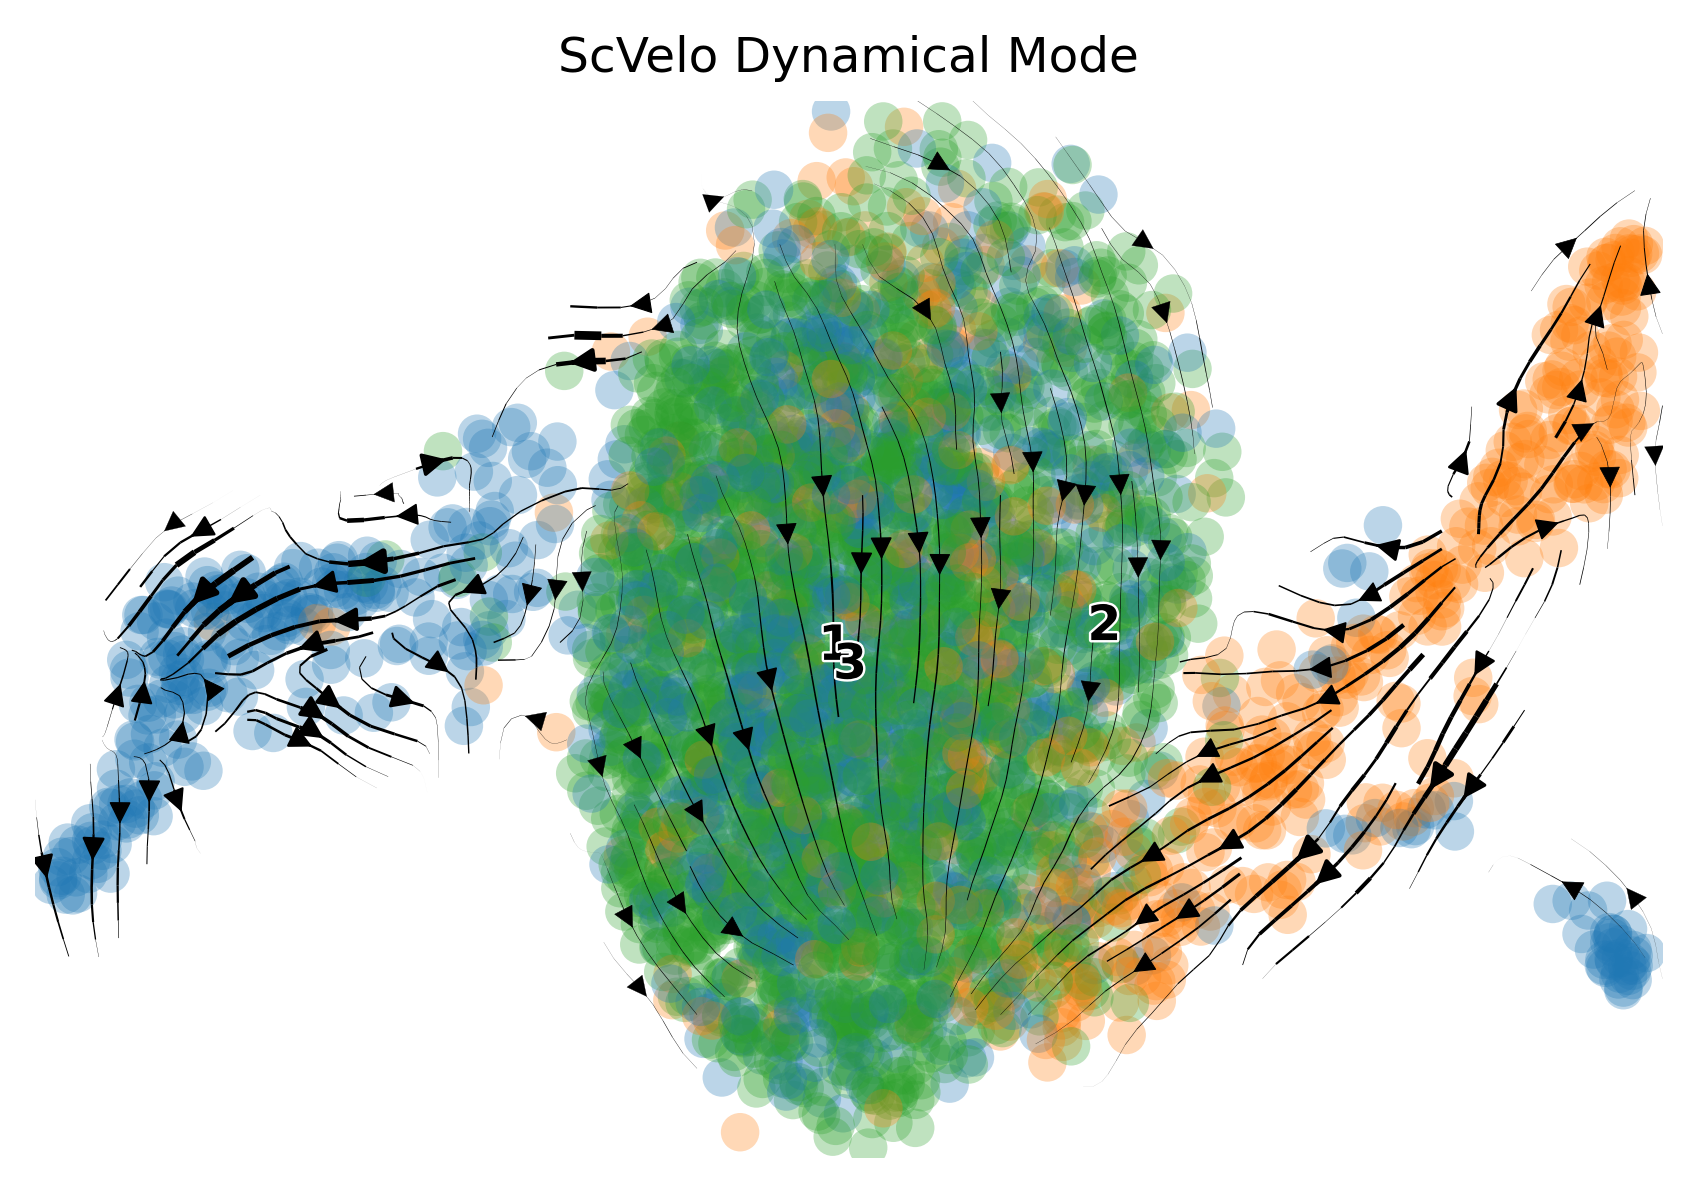

--> added 'dyn_velocity_length' (adata.obs)
--> added 'dyn_velocity_confidence' (adata.obs)
--> added 'dyn_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.074820295, ('3', '2'): 0.04053026}
Total Mean: 0.057675279676914215
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.6841035878449254, ('3', '2'): 0.696925354831937}
Total Mean: 0.6905144713384312
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.07670071406471285, ('3', '2'): 0.0937786497491194}
Total Mean: 0.08523968190691612
# In-cluster Coherence
{'1': 0.7128571280204723, '2': 0.7443755904530255, '3': 0.7148767141699167}
Total Mean: 0.7240364775478049
# In-cluster Confidence
{'1': 0.761163003645351, '2': 0.7630339294852572, '3': 0.7790149487081088}
Total Mean: 0.7677372939462389


In [7]:
scv.tl.recover_dynamics(adata, use_raw=False, var_names="all", n_jobs=10)
scv.tl.velocity(adata, vkey='dyn_velocity', mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="dyn_velocity", color=[k_cluster], basis='X_umap', dpi=350,
                                title='ScVelo Dynamical Mode', save="scEU_dynamical.png")
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
sel = ~np.isnan(adata.var.fit_likelihood)
exp_metrics['dyn_mode'] = evaluate(adata[:, sel], cluster_edges, k_cluster, "dyn_velocity", 'X_umap')

In [8]:
with open("dyn_scEU.pkl", 'wb') as ofile:
    pickle.dump(exp_metrics, ofile)

In [9]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


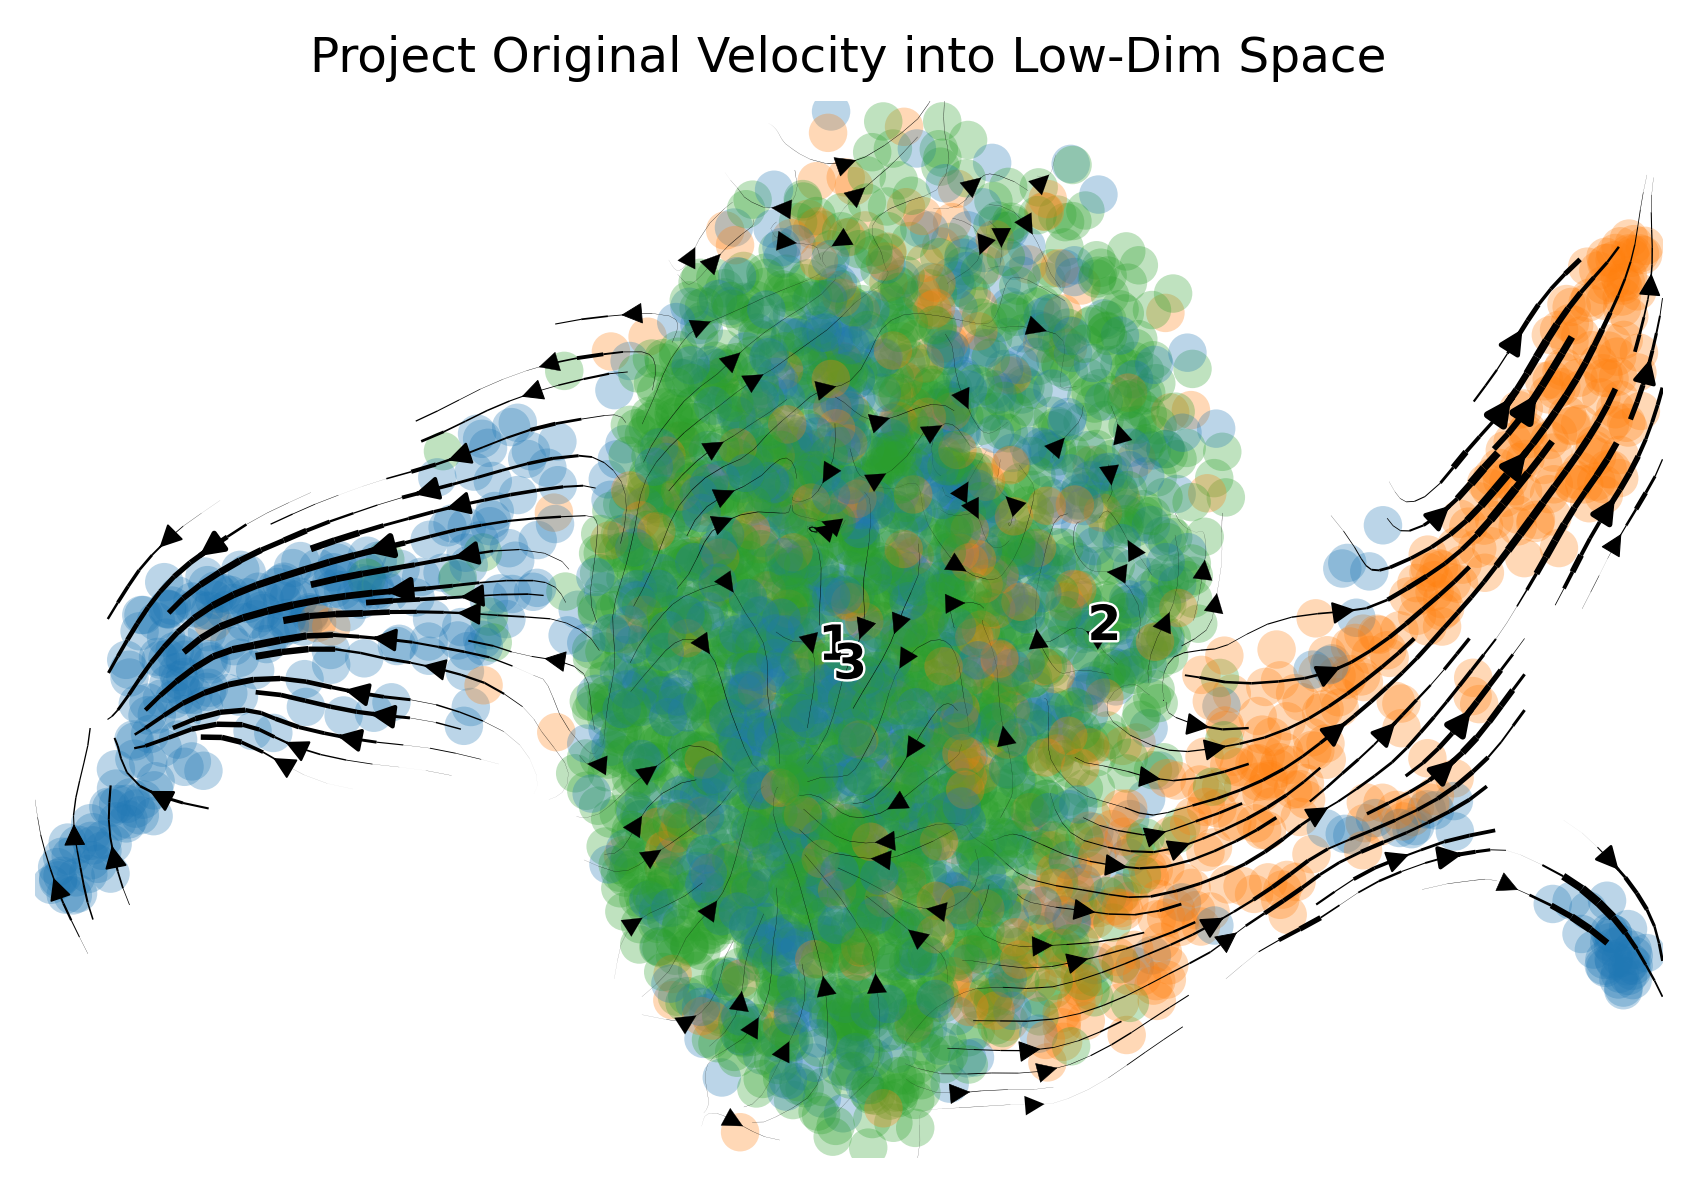

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.3336818, ('3', '2'): 0.30480924}
Total Mean: 0.31924551725387573
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.9995657, ('3', '2'): 0.9995725}
Total Mean: 0.9995691180229187
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.11931244771926564, ('3', '2'): 0.13469771985947593}
Total Mean: 0.12700508378937078
# In-cluster Coherence
{'1': 0.999671, '2': 0.99964094, '3': 0.99964243}
Total Mean: 0.9996514320373535
# In-cluster Confidence
{'1': 0.9994885963418626, '2': 0.9994790397499358, '3': 0.9995535378728932}
Total Mean: 0.9995070579882306


In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    new_v_key = "new_velocity"
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, new_v_key=new_v_key)
    scv.tl.velocity_graph(adata, vkey=new_v_key)
    scv.tl.velocity_confidence(adata, vkey=new_v_key)
    scv.pl.velocity_embedding_stream(adata, vkey=new_v_key, basis='X_umap', color='monocle_branch_id', dpi=350, title="Project Original Velocity into Low-Dim Space")
    evaluate(adata, cluster_edges, k_cluster, new_v_key)
    return x, u, s, v
    
x, u, s, v = exp(adata, exp_metrics)

In [11]:
import seaborn as sns
def draw():
    ordered_sel_branch2 = (adata.obs.monocle_branch_id == "2").values
    ordered_sel_branch2 = np.argwhere(ordered_sel_branch2 == True).flatten()
    ordered_sel_branch2, _ = zip(*sorted(zip(ordered_sel_branch2, adata.obs.monocle_pseudotime[ordered_sel_branch2]), key=lambda xy: xy[1]))
    ordered_sel_branch2 = np.array(ordered_sel_branch2)
    X_std = x[ordered_sel_branch2].T
    df2 = pd.DataFrame(X_std, columns=ordered_sel_branch2)
    return df2
df2z = draw()

In [12]:
def draw():
    ordered_sel_branch1 = (adata.obs.monocle_branch_id == "1").values
    ordered_sel_branch1 = np.argwhere(ordered_sel_branch1 == True).flatten()
    ordered_sel_branch1, _ = zip(*sorted(zip(ordered_sel_branch1, adata.obs.monocle_pseudotime[ordered_sel_branch1]), key=lambda xy: xy[1]))
    ordered_sel_branch1 = np.array(ordered_sel_branch1)
    X_std = x[ordered_sel_branch1].T
    df1 = pd.DataFrame(X_std, columns=ordered_sel_branch1)
    return df1
df1z = draw()

In [13]:
def merge():
    from scipy.special import softmax
    dfmz = pd.concat([df1z, df2z], axis=1)
    values = dfmz.values
    values = (values - np.min(values, axis=1, keepdims=True)) / (np.max(values, axis=1, keepdims=1) - np.min(values, axis=1, keepdims=True))
    dfmz = pd.DataFrame(softmax(values, axis=1) * 1e3)
    dfmz.columns = pd.Series(np.concatenate([np.round(adata.obs.monocle_pseudotime[df1z.columns],2),
                                             np.round(adata.obs.monocle_pseudotime[df2z.columns],2)]), 
                             name="monocle_pseudotime")
    return dfmz
dfmz = merge()    

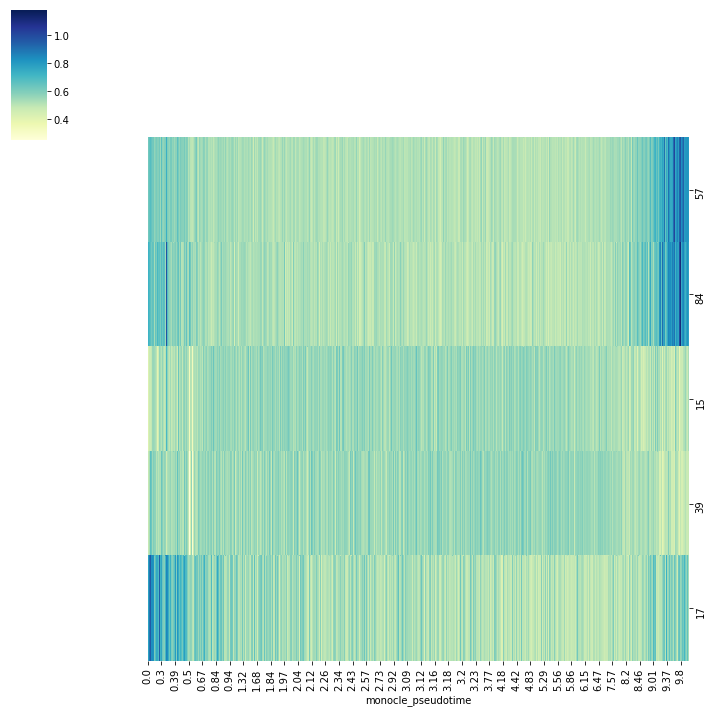

In [14]:
# 57, 84, 15, 39, 17
ordered_dim_list = [57, 84,
                    15,
                    39, 17]
ax = sns.clustermap(dfmz.iloc[ordered_dim_list], cmap="YlGnBu", row_cluster=False, col_cluster=False, yticklabels=True)
ax.savefig(f"./figures/{args.exp_name}_low_dim_x.png", dpi=350)

In [15]:
sel_3 = (adata.obs.monocle_branch_id == '3').values
sel_2 = (adata.obs.monocle_branch_id == '2').values
sel_1 = (adata.obs.monocle_branch_id == '1').values
start_sel = []

for ith, nb in enumerate(adata.uns['neighbors']['indices'][sel_2]):
    for idx in nb:
        if sel_3[idx] == True:
            edge_node = np.argwhere(sel_2 == True).flatten()[ith]
            start_sel.append(edge_node)
            break

In [16]:
def exp():
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        gen_x, raw_x = model.encoder(tensor_x, True)
        attens = model.decoder(raw_x, gen_x, True)[1].detach().cpu().numpy()
    return attens
    
attens = exp()

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
interested_genes = ["Apoa1", "Ephx2", "Cyp3a25", "Gstm3", "Muc3", 
                    'Dclk1',
                    'Defa24', 'Defa17', 'Rnase4', 'Lyz1']
int_gene_indices = [np.argwhere((adata.var.gene == gene).values).item() for gene in interested_genes]
        
target_attens = attens[:, int_gene_indices]
hard_assignments = {}
for _x, _y in zip(np.argmax(target_attens, axis=0), interested_genes):
    hard_assignments[_y] = _x
#     print(f'\tGene {y}, \t attention hard assigned to low-dim {x}')
    
from collections import Counter
cluster_stats = Counter(hard_assignments.values())
cluster_stats

Counter({57: 1, 84: 5, 15: 1, 39: 1, 17: 2})

In [18]:
hard_assignments

{'Apoa1': 57,
 'Ephx2': 84,
 'Cyp3a25': 84,
 'Gstm3': 84,
 'Muc3': 84,
 'Dclk1': 15,
 'Defa24': 39,
 'Defa17': 17,
 'Rnase4': 84,
 'Lyz1': 17}

In [19]:
for _x, _y in zip(np.argmax(target_attens, axis=0), interested_genes):
    if _y == "Apoa1":
        print('Genes most indicatve of Branch 2')
    if _y == "Defa24":
        print('Gene most indicatve of Branch 1')
    if _y == "Lgr5":
        print('other')
    if _y == "Dclk1":
        print('Gene most indicatve of Tuft cells')
    print(f'\tGene {_y}, \t attention hard assigned to low-dim {_x}')

Genes most indicatve of Branch 2
	Gene Apoa1, 	 attention hard assigned to low-dim 57
	Gene Ephx2, 	 attention hard assigned to low-dim 84
	Gene Cyp3a25, 	 attention hard assigned to low-dim 84
	Gene Gstm3, 	 attention hard assigned to low-dim 84
	Gene Muc3, 	 attention hard assigned to low-dim 84
Gene most indicatve of Tuft cells
	Gene Dclk1, 	 attention hard assigned to low-dim 15
Gene most indicatve of Branch 1
	Gene Defa24, 	 attention hard assigned to low-dim 39
	Gene Defa17, 	 attention hard assigned to low-dim 17
	Gene Rnase4, 	 attention hard assigned to low-dim 84
	Gene Lyz1, 	 attention hard assigned to low-dim 17


(1208,)


Text(0.5, 1.0, 'Square Root of Observed Expression of Branch 1 Cells')

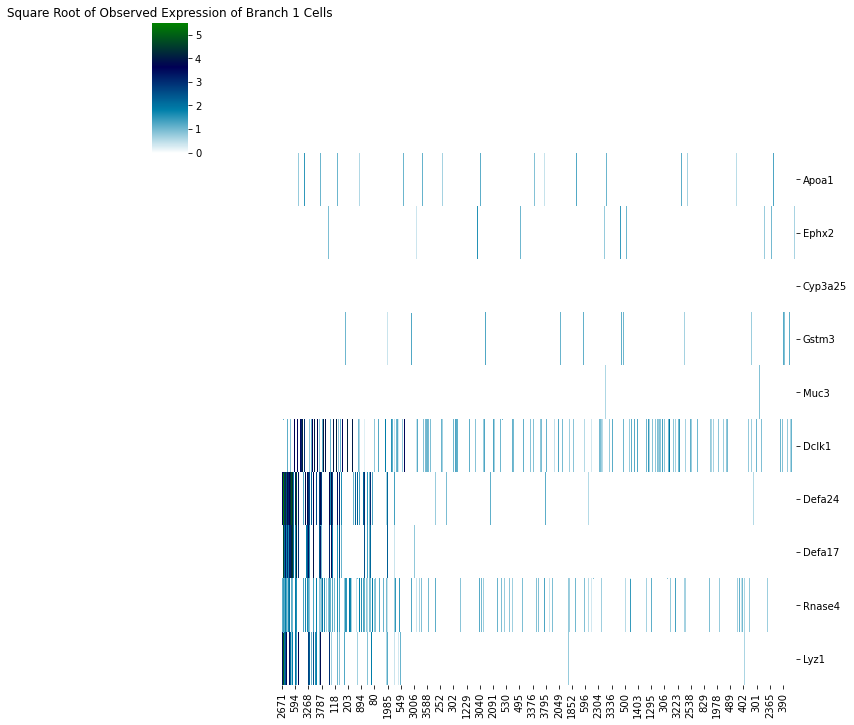

In [20]:
ordered_sel_branch1 = (adata.obs.monocle_branch_id == "1").values
ordered_sel_branch1 = np.argwhere(ordered_sel_branch1 == True).flatten()
print(np.shape(ordered_sel_branch1))
ordered_sel_branch1, _ = zip(*sorted(zip(ordered_sel_branch1, adata.obs.monocle_pseudotime[ordered_sel_branch1]), key=lambda xy: xy[1]))
ordered_sel_branch1 = np.array(ordered_sel_branch1)
data = np.log(tensor_x.cpu().numpy()[ordered_sel_branch1].T[int_gene_indices] + 1)
df1 = pd.DataFrame(data, columns=ordered_sel_branch1, index=interested_genes)
ax = sns.clustermap(df1, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Square Root of Observed Expression of Branch 1 Cells")

(613,)


Text(0.5, 1.0, 'Square Root of Observed Expression of Branch 2 Cells')

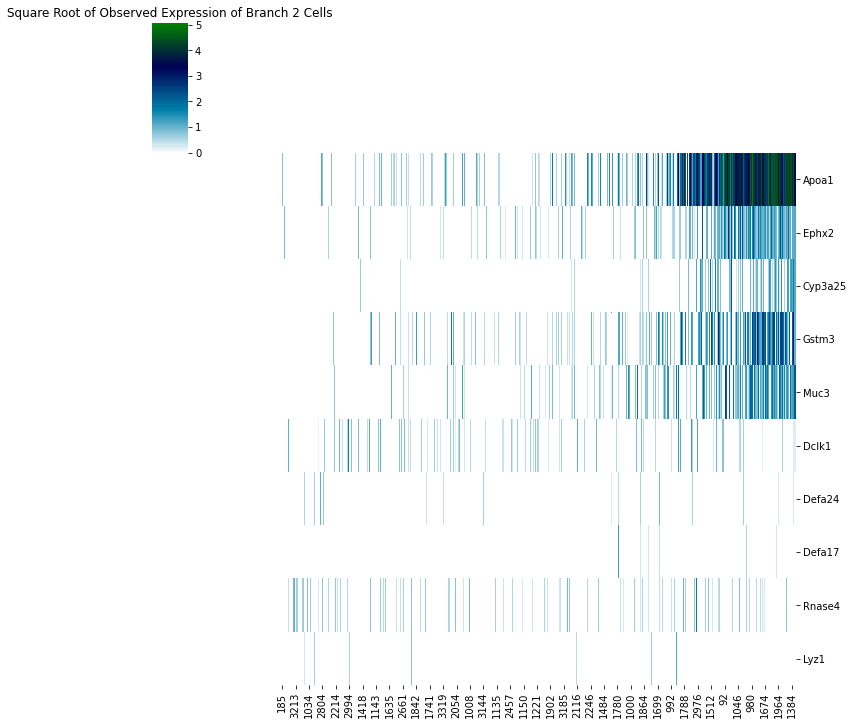

In [21]:
ordered_sel_branch2 = (adata.obs.monocle_branch_id == "2").values
ordered_sel_branch2 = np.argwhere(ordered_sel_branch2 == True).flatten()
print(np.shape(ordered_sel_branch2))
ordered_sel_branch2, _ = zip(*sorted(zip(ordered_sel_branch2, adata.obs.monocle_pseudotime[ordered_sel_branch2]), key=lambda xy: xy[1]))
ordered_sel_branch2 = np.array(ordered_sel_branch2)

data = np.log(tensor_x.cpu().numpy()[ordered_sel_branch2].T[int_gene_indices] + 1)
df2 = pd.DataFrame(data, columns=ordered_sel_branch2, index=interested_genes)
ax = sns.clustermap(df2, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Square Root of Observed Expression of Branch 2 Cells")

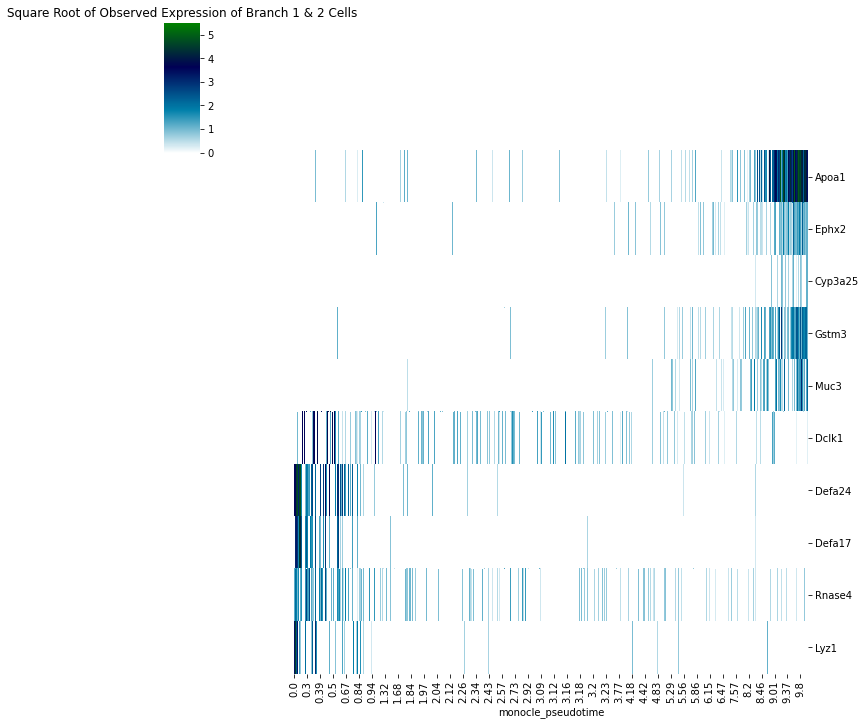

In [22]:
df_m = pd.concat([df1, df2], axis=1)
df_m.columns = adata.obs.monocle_pseudotime[np.concatenate([df1.columns, df2.columns])].round(2)
ax = sns.clustermap(df_m, cmap="ocean_r", row_cluster=False, col_cluster=False)
plt.title("Square Root of Observed Expression of Branch 1 & 2 Cells")
ax.savefig(f"./figures/{args.exp_name}_fig3f_rep.png")

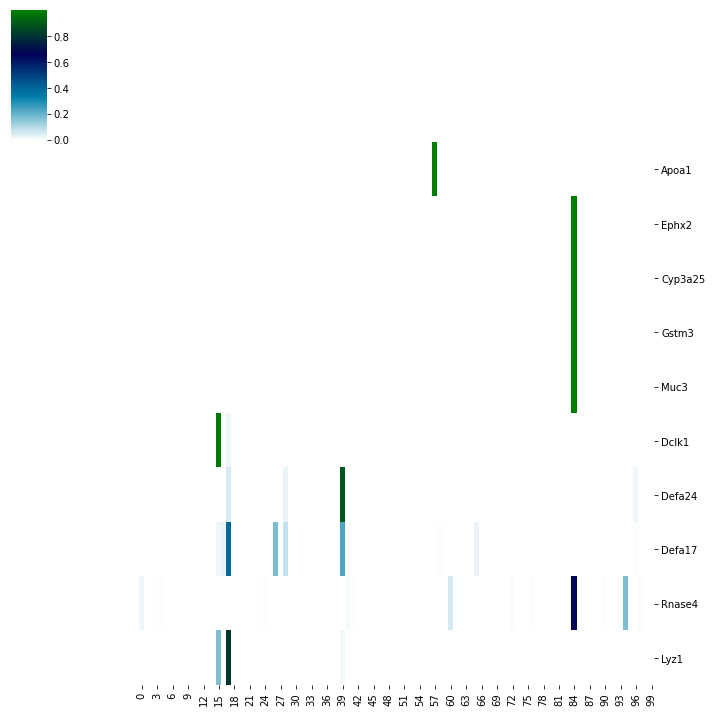

In [23]:
df_gene_atten = pd.DataFrame(np.power(attens[:, int_gene_indices].T, 1), index=interested_genes)
ax = sns.clustermap(df_gene_atten, col_cluster=False, row_cluster=False, cmap="ocean_r")
ax.savefig(f"./figures/{args.exp_name}_atten_hard_cluster.png", dpi=350)